<a href="https://colab.research.google.com/github/Timure228/LSTM_Based_Text_Generator/blob/main/LSTM_Text_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Text Generator

In [73]:
import torch
from torch import nn
from torch.nn import RNN, LSTM, Dropout

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import regex
import string

import numpy as np

In [74]:
FILE = "all(2M).txt"
with open(FILE, "r") as f:
  lines_amount = f.read().count("\n") + 1

lines_amount

21254

In [75]:
translator = str.maketrans('', '', string.punctuation)

In [76]:
import re

with open(FILE, "r") as f:
  text = f.read()
  text = text.strip().translate(translator).lower()
  text = text[:int(len(text)*0.5)]
  print(text.count("\n") + 1)

# print(f"Before: {len(text)}")

# text = re.sub('\)', '',text)
# text = re.sub('\(', '',text)

# for pattern in set(re.findall('<unk>', text)):
#   text = re.sub(pattern, '', text)

# print(f"After: {len(text)}")

8470


In [77]:
train_text = text[:int(len(text)*0.8)]
test_text = text[int(len(text)*0.8):]

In [78]:
# Tokenize
tokens = []
for i in text.split():
  for j in i.split():
    tokens.append(j)

tokens = list(set(tokens))
vocab_size = len(tokens)
tokens[:10]

['£82bn',
 'sprawling',
 'bomblarbi',
 'gives',
 'titled',
 'ambitious',
 'cans',
 'buttons',
 'sharapovas',
 'harry']

In [79]:
indx_to_token = {indx: token for indx, token in enumerate(tokens)}
token_to_indx = {token: indx for indx, token in enumerate(tokens)}

In [80]:
# Create encode and decode function
def encode(arr: list, token_to_indx=token_to_indx):
  try:
    for i in arr:
      for j in range(len(i)):
        i[j] = token_to_indx[i[j]]
  except KeyError:
    print(i)
    print(i[j])
    i.remove(i[j])
  return arr

def decode(arr: list, indx_to_token=indx_to_token):
  for i in arr:
    for j in range(len(i)):
      i[j] = indx_to_token[i[j]]
  return arr


In [81]:
SEQ_LENGTH = 10

def create_sequence(X: list, y: list, text: str, SEQ_LENGTH = SEQ_LENGTH, STEP=1):
  text_arr = text.split()
  for i in range(0, len(text_arr)- SEQ_LENGTH, STEP):
    X.append(text_arr[i:i + SEQ_LENGTH])
    y.append([text_arr[i+SEQ_LENGTH]])
  return X, y

In [ ]:
# Creating the sequences
X_train = []
y_train = []

X_test = []
y_test = []

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=10)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=10)

X_test[1], y_test[1]

(['the',
  'war',
  'to',
  'president',
  'chirac',
  'asking',
  'that',
  'october',
  '31',
  'be'],
 ['made'])

In [ ]:
# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

In [ ]:
X_test = encode(X_test)
y_test = encode(y_test)

In [ ]:
# Padding X and y
X_train_padded = pad_sequences(X_train, maxlen=10, padding='post', value=0)  # 'post' means pad at the end of each sequence
y_train_padded = pad_sequences(y_train, maxlen=10, padding='post', value=0)

X_test_padded = pad_sequences(X_test, maxlen=10, padding='post', value=0)
y_test_padded = pad_sequences(y_test, maxlen=10, padding='post', value=0)

In [ ]:
print(f"X Shape: {X_train_padded.shape} | y shape: {y_train_padded.shape}")

X Shape: (33998, 10) | y shape: (33998, 10)


In [ ]:
# Converting X and y to categorical vectors
X_train_cat = to_categorical(X_train_padded, num_classes=vocab_size)
y_train_cat = to_categorical(y_train_padded, num_classes=vocab_size)

In [ ]:
X_test_cat = to_categorical(X_test_padded, num_classes=vocab_size)
y_test_cat = to_categorical(y_test_padded, num_classes=vocab_size)

In [ ]:
len(X_train_cat[133])

10

In [ ]:
# Check the ranks of X and y
print(f"X Rank: {tf.rank(X_train_cat)} | y Rank: {tf.rank(y_train_cat)}")
print(f"X Shape: {X_train_cat.shape} | y shape: {y_train_cat.shape}")
print(f"X Type: {type(X_train_cat)} | y Type: {type(y_train_cat)}")

X Rank: 3 | y Rank: 3
X Shape: (1354, 10, 720) | y shape: (1354, 10, 720)
X Type: <class 'numpy.ndarray'> | y Type: <class 'numpy.ndarray'>


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

# TensorFlow Based

In [ ]:
model = Sequential()
model.add(keras.layers.Input(shape=(41, X_train_cat.shape[2])))
model.add(Dropout(rate=0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_cat, y_train_cat, epochs=50, verbose=1)

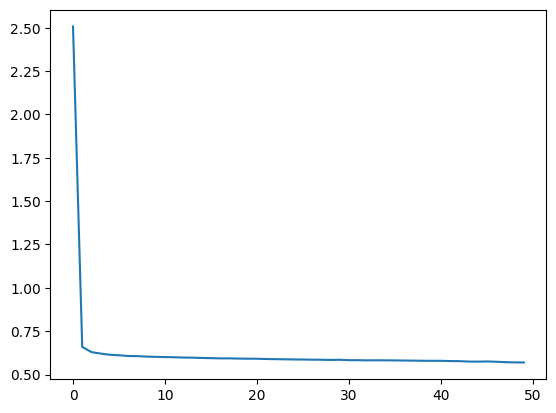

In [ ]:
# Plot the Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["loss"])

In [ ]:
# Model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 41, 1197)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 41, 128)             │         678,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 41, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 41, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 41, 1197)            │          77,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,430,857 (9.27 MB)

 Trainable params: 810,285 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,620,572 (6.18 MB)

In [ ]:
input_string = [["why", "those", "people", "so", "about"]]

def convert(string):
  input_string_arr = [token_to_indx[i] for i in input_string[0]]
  input_string_arr = pad_sequences(input_string_arr, maxlen=10, padding="pre", value=0)
  input_string_arr = tf.keras.utils.to_categorical(input_string_arr, num_classes=vocab_size)
  return input_string_arr

input_string_arr = convert(input_string)


y_preds = model.predict(input_string_arr)
labels = tf.argmax(y_preds, axis=2)

print([decode(input_string)[0] + [indx_to_token[int(labels[0][i])] for i in range(len(labels)) if int(labels[0][i]) != 0]])
labels

KeyError: 'why'

In [ ]:
# Evaluating the model
model.evaluate(X_test_cat, y_test_cat)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9047 - loss: 0.7137


[0.7272857427597046, 0.9033333659172058]

In [ ]:
model.save("model_0.keras")

# PyTorch Based

In [82]:
X_train = []
y_train = []

X_test = []
y_test = []

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=10)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=10)

# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

X_test = encode(X_test)
y_test = encode(y_test)

In [83]:
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(len(X_train), SEQ_LENGTH) / vocab_size
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(len(X_test), SEQ_LENGTH) / vocab_size
y_test = torch.tensor(y_test, dtype=torch.float32)

In [31]:
class Model0(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(Model0, self).__init__()
    self.layer_dim = layer_dim
    self.hidden_dim = hidden_dim

    self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_dim,
                     batch_first=True)
    self.linear = torch.nn.Linear(hidden_dim, output_dim)
    self.softMax = torch.nn.Softmax()

  def forward(self, x, h0=None, c0=None):
    if h0 is None and c0 is None:
      h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
      c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

    out, (hn, hc) = self.lstm(x, (h0, c0))
    out = self.linear(out[:, -1, :])
    return out, hn, hc

In [84]:
class Model1(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, dropout=0.2)
    self.linear = nn.Linear(128, out_features=output_size)

  def forward(self, x):
    x, _ = self.lstm(x)
    x = x[:, -1]
    x = self.linear(x)
    return x

In [85]:
model1 = Model1(input_size=SEQ_LENGTH, hidden_size=256, output_size=128)
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [86]:
batch_size = 128

train_dataset_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
test_dataset_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=batch_size)

https://machinelearningmastery.com/text-generation-with-lstm-in-pytorch/

In [142]:
## Training loop for model 1
from torch.utils import data

EPOCHS = 10

for epoch in range(EPOCHS):
  model1.train()
  for X_train, y_train in train_dataset_loader:
    if len(X_train) == 48:
      continue

    y_pred = model1(X_train)

    loss = loss_fn(y_pred, y_train.squeeze(1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  # Validation
  model1.eval()
  loss = 0
  with torch.no_grad():
    for X_train, y_train in train_dataset_loader:
        if len(X_train) == 48:
          continue
        y_pred = model1(X_train)
        loss += loss_fn(y_pred, y_train.squeeze(1))
    if (epoch + 1) % 5 == 0:
      print(f"Epoch: {epoch + 1} | Loss: {loss:.4f}")

Epoch: 5 | Loss: 8053442560.0000
Epoch: 10 | Loss: 8053238272.0000


In [168]:
custom_string = "this thing is based on the new type of the"
X_custom = [[]]

for i in custom_string.split():
  X_custom[0].append(i)

# Encoding, converting to numerical
X_custom = encode(X_custom)

In [169]:
X_custom = torch.tensor(X_custom, dtype=torch.float32) / vocab_size

In [170]:
model1(X_custom)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 128x128)

In [ ]:
def nuke(n):
  a = []
  for i in range(10):
    if n > 1:
      a.append(nuke(n-1))
    else:
      a.append(i)
  return a

# print(nuke(10))